In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_MODELS_FOLDER = "/content/drive/MyDrive/VNS Data/TinyML Models"

# Parameter Estimation
The model and dataset below was implemented to estimate the required amplitude given the activation level, pulse width, fibre type, and other features

In [3]:
from keras import Model, Input, layers, optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv(f'{DATA_MODELS_FOLDER}/vns_dataset_threshold_type.csv')

data.loc[data['fibre_type'] == 'AB', 'fibre_type'] = 0.0
data.loc[data['fibre_type'] == 'C', 'fibre_type'] = 1.0

# Encode the categorical feature
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

X_cat = one_hot_encode(data[['fibre_type']].astype('int'), num_classes=2)
X_cat = X_cat.reshape(-1, 2)

# Split the data
X = data.loc[:, ['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']]
X.loc[:, 'fibre_type_AB'] = X_cat[:, 0]
X.loc[:, 'fibre_type_C'] = X_cat[:, 1]
y = data.loc[:, ['amplitude']]

In [4]:
X_ab = X[X['fibre_type_AB'] == 1.0]
X_c = X[X['fibre_type_C'] == 1.0]
y_ab = y[X['fibre_type_AB'] == 1.0]
y_c = y[X['fibre_type_C'] == 1.0]

# Normalize the continuous features
X_scaler_ab = StandardScaler()
X_ab_norm = X_scaler_ab.fit_transform(X_ab[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])
X_scaler_c = StandardScaler()
X_c_norm = X_scaler_c.fit_transform(X_c[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])

y_scaler_ab = StandardScaler()
y_ab_norm = y_scaler_ab.fit_transform(y_ab)
y_scaler_c = StandardScaler()
y_c_norm = y_scaler_c.fit_transform(y_c)

X_ab_norm = np.hstack([X_ab_norm, X_ab[['fibre_type_AB', 'fibre_type_C']].values])
X_c_norm = np.hstack([X_c_norm, X_c[['fibre_type_AB', 'fibre_type_C']].values])

X_norm = np.vstack([X_ab_norm, X_c_norm])
y_norm = np.vstack([y_ab_norm, y_c_norm])

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

In [5]:
import pickle
# load the model back
with open(f'{DATA_MODELS_FOLDER}/parameter-model-mlp.pkl', 'rb') as f:
    parameter_model = pickle.load(f)

parameter_model.summary()

Model: "functional_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_559 (Dense)                    │ (None, 929)                 │           7,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_560 (Dense)                    │ (None, 239)                 │         222,270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_561 (Dense)                    │ (None, 1)                   │             240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 689,828 (2.63 MB)

 Trainable params: 229,942 (898.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 459,886 (1.75 MB)

The model has already been trained but here is the code for it.

In [6]:
# Train the loaded model
# history = parameter_model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.2,
# )

final_score = parameter_model.evaluate(X_test, y_test)
print(f"Final score (test MSE): {final_score[0]}")

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109 - mae: 0.0344
Final score (test MSE): 0.010248959064483643


In [7]:
# Get test predictions
# Generate predictions
y_pred = parameter_model.predict(X_test)

# Inverse transform the predictions
y_pred_denorm = y_pred.copy()
y_test_denorm = y_test.copy()
y_pred_denorm[X_test[:, 5] == 1.0, :] = y_scaler_ab.inverse_transform(y_pred[X_test[:, 5] == 1.0, :])
y_test_denorm[X_test[:, 5] == 1.0, :] = y_scaler_ab.inverse_transform(y_test[X_test[:, 5] == 1.0, :])
y_pred_denorm[X_test[:, 6] == 1.0, :] = y_scaler_c.inverse_transform(y_pred[X_test[:, 6] == 1.0, :])
y_test_denorm[X_test[:, 6] == 1.0, :] = y_scaler_c.inverse_transform(y_test[X_test[:, 6] == 1.0, :])

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [8]:
y_test.shape

(6482, 1)

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

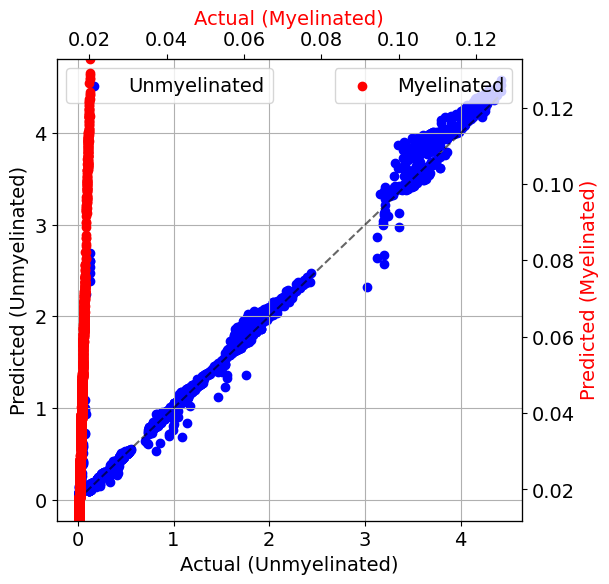

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot diagonal line for comparison (on primary axis for unmyelinated data)
ax1.plot([0, max(y_test_denorm)[0]], [0, max(y_test_denorm)[0]], color='k', linestyle='--', alpha=0.6)

# Plot for Unmyelinated data on the primary axes
ax1.scatter(y_test_denorm[X_test[:, 6] == 1.0, :], y_pred_denorm[X_test[:, 6] == 1.0, :],
            label='Unmyelinated', color='blue')
ax1.set_xlabel('Actual (Unmyelinated)')
ax1.set_ylabel('Predicted (Unmyelinated)')

# Create secondary axes for Myelinated data
ax2 = ax1.twinx()  # Right Y-axis for myelinated predicted values
ax3 = ax1.twiny()  # Top X-axis for myelinated actual values

# Plot for Myelinated data on the secondary axes
ax2.scatter(y_test_denorm[X_test[:, 5] == 1.0, :], y_pred_denorm[X_test[:, 5] == 1.0, :],
            label='Myelinated', color='red')

# Set proper scaling for the secondary axes based on myelinated data
ax3.set_xlim(min(y_test_denorm[X_test[:, 5] == 1.0, :]), max(y_test_denorm[X_test[:, 5] == 1.0, :]))
ax2.set_ylim(min(y_pred_denorm[X_test[:, 5] == 1.0, :]), max(y_pred_denorm[X_test[:, 5] == 1.0, :]))

# Set labels for the secondary axes
ax2.set_ylabel('Predicted (Myelinated)', color='red')
ax3.set_xlabel('Actual (Myelinated)', color='red')

# Grid and legend
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


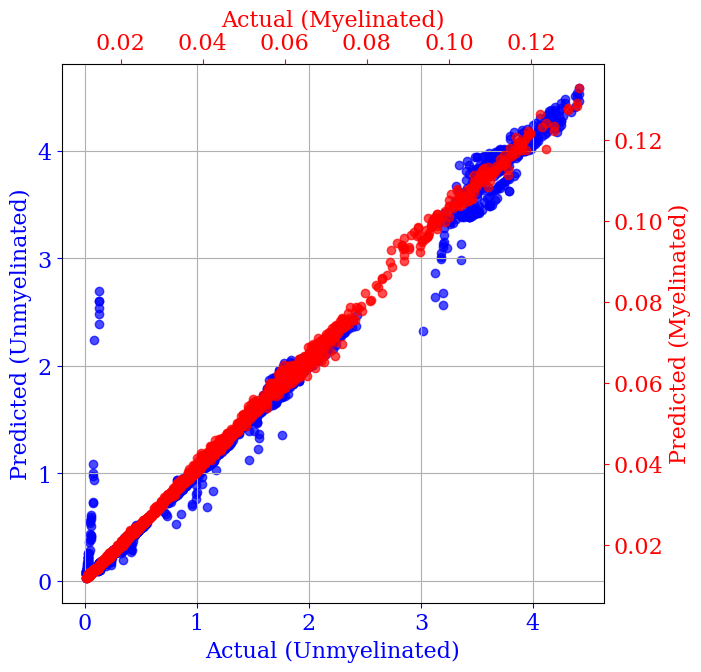

In [15]:
fig=plt.figure(figsize=(7, 7))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.scatter(y_test_denorm[X_test[:, 6] == 1.0, :], y_pred_denorm[X_test[:, 6] == 1.0], color="blue", alpha=0.7)
ax.set_xlabel("Actual (Unmyelinated)", color="blue")
ax.set_ylabel("Predicted (Unmyelinated)", color="blue")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")
ax.grid(True)

ax2.scatter(y_test_denorm[X_test[:, 5] == 1.0, :], y_pred_denorm[X_test[:, 5] == 1.0], color="red", alpha=0.7)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Actual (Myelinated)", color="red")
ax2.set_ylabel("Predicted (Myelinated)", color="red")
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")


plt.savefig('mlp-results.eps', dpi=400, format='eps')
plt.show()


In [ ]:
plt.savefig('mlp-results.png', dpi=400)


<Figure size 640x480 with 0 Axes>

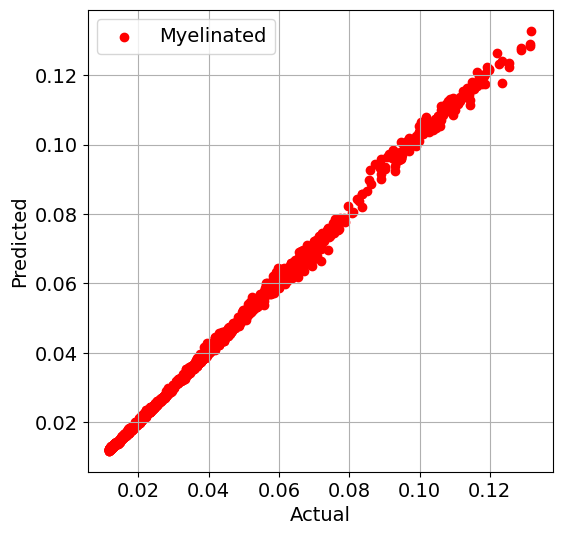

In [ ]:
plt.figure(figsize=(6, 6))
# plt.plot([0, max(y_test_denorm)[0]], [0, max(y_test_denorm)[0]], color='k', linestyle='--', alpha=0.6)
# plt.scatter(y_test_denorm[X_test[:, 6] == 1.0, :], y_pred_denorm[X_test[:, 6] == 1.0, :], label='Unmyelinated', color='blue')
plt.scatter(y_test_denorm[X_test[:, 5] == 1.0, :], y_pred_denorm[X_test[:, 5] == 1.0, :], label='Myelinated', color='red')
plt.grid(True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
# plt.savefig('mlp-results.png', dpi=400)
plt.show()

# Activation Level Estimation
The below network is a CNN which estimates the activation level from the input stimulation and the CNAP waveform.

In [ ]:
# %reset -f

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
DATA_MODELS_FOLDER = "/content/drive/MyDrive/VNS Data/TinyML Models"

# Load the CSV files
stimulus_data = pd.read_csv(f'{DATA_MODELS_FOLDER}/vns_stimulations.csv', header='infer').values
response_data = pd.read_csv(f'{DATA_MODELS_FOLDER}/vns_responses.csv', header='infer').values

stimulus_data = stimulus_data[:,1:].T
response_data = response_data[:,1:].T

vns_data = pd.read_csv(f'{DATA_MODELS_FOLDER}/vns_cervical_rat_data.csv')
activation_data = vns_data[['AB_fibers_activation', 'C_fibers_activation']].values

# print the sizes with text
print('stimulus_data:', stimulus_data.shape)
print('response_data:', response_data.shape)
print('activation_data:', activation_data.shape)

stimulus_data: (13702, 2498)
response_data: (13702, 2498)
activation_data: (13702, 2)


In [17]:
from sklearn.preprocessing import StandardScaler

# Reshape data to 2D for scaling (samples, features)
stimulus_data_2d = stimulus_data.reshape((stimulus_data.shape[0], -1))
response_data_2d = response_data.reshape((response_data.shape[0], -1))

stim_scaler = StandardScaler()
stimulus_data_standardized = stim_scaler.fit_transform(stimulus_data_2d)
response_scaler = StandardScaler()
response_data_standardized = response_scaler.fit_transform(response_data_2d)

# Reshape back to original 3D shape (samples, timesteps, 1)
stimulus_data_standardized = stimulus_data_standardized.reshape((stimulus_data.shape[0], stimulus_data.shape[1], 1))
response_data_standardized = response_data_standardized.reshape((response_data.shape[0], response_data.shape[1], 1))

# standardize activation data
activation_scaler = StandardScaler()
activation_data_std = activation_scaler.fit_transform(activation_data)

# Split the data into training and testing sets
X_stimulus_train, X_stimulus_test, X_response_train, X_response_test, y_train, y_test = train_test_split(
    stimulus_data_standardized, response_data_standardized, activation_data_std, test_size=0.2, random_state=42)

X_stimulus_train, X_stimulus_val, X_response_train, X_response_val, y_train, y_val = train_test_split(
    X_stimulus_train, X_response_train, y_train, test_size=0.25, random_state=17)

In [18]:
# Import the model
import pickle
with open(f'{DATA_MODELS_FOLDER}/activation-model-cnn-clean.pkl', 'rb') as f:
    activation_model = pickle.load(f)

activation_model.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ stimulus_input            │ (None, 2498, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ response_input            │ (None, 2498, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_148 (Conv1D)       │ (None, 2495, 32)       │            160 │ stimulus_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_151 (Conv1D)       │ (None, 2494, 8)        │             48 │ response_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_148         │ (None, 1247, 32)       │              0 │ conv1d_148[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_151         │ (None, 1247, 8)        │              0 │ conv1d_151[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_149 (Conv1D)       │ (None, 622, 8)         │          1,288 │ max_pooling1d_148[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_152 (Conv1D)       │ (None, 1245, 64)       │          1,600 │ max_pooling1d_151[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_149         │ (None, 155, 8)         │              0 │ conv1d_149[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_152         │ (None, 622, 64)        │              0 │ conv1d_152[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_150 (Conv1D)       │ (None, 151, 8)         │            328 │ max_pooling1d_149[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_153 (Conv1D)       │ (None, 619, 32)        │          8,224 │ max_pooling1d_152[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_150         │ (None, 50, 8)          │              0 │ conv1d_150[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_153         │ (None, 154, 32)        │              0 │ conv1d_153[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_102 (Flatten)     │ (None, 400)            │              0 │ max_pooling1d_150[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_103 (Flatten)

 Total params: 66,920 (261.41 KB)

 Trainable params: 22,306 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,614 (174.28 KB)

This model has also already been trained.

In [19]:
# Train the best model
# history = activation_model.fit(
#     [X_stimulus_train, X_response_train], y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=([X_stimulus_val, X_response_val], y_val)
# )

# Evaluate the best model
final_score = activation_model.evaluate([X_stimulus_test, X_response_test], y_test)
print(f"Final score (test MSE): {final_score[0]}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0015 - mean_absolute_error: 0.0126
Final score (test MSE): 0.0012535094283521175


In [20]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
# Generate predictions
y_pred = activation_model.predict([X_stimulus_test, X_response_test])
y_pred_denorm = activation_scaler.inverse_transform(y_pred)
y_test_denorm = activation_scaler.inverse_transform(y_test)

86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step


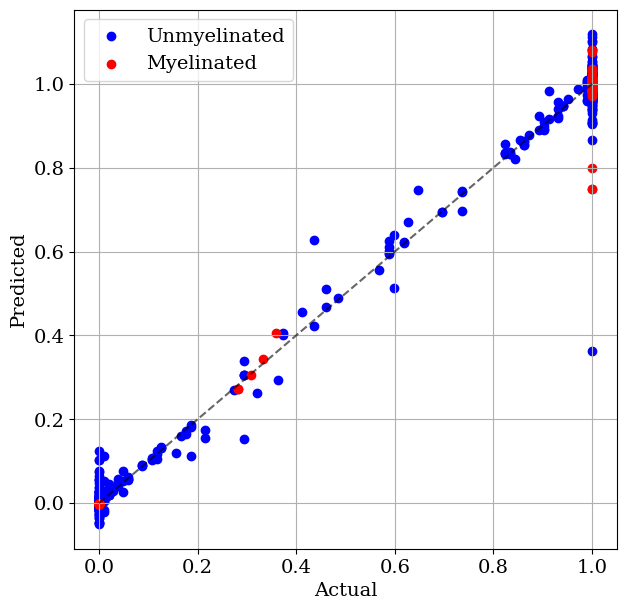

In [24]:
# Plot the results
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], color='k', linestyle='--', alpha=0.6)
plt.scatter(y_test_denorm[:, 1], y_pred_denorm[:, 1], label='Unmyelinated', color='blue')
plt.scatter(y_test_denorm[:, 0], y_pred_denorm[:, 0], label='Myelinated', color='red')
plt.grid(True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.savefig('cnn-results.eps', dpi=400, format='eps')
plt.show()

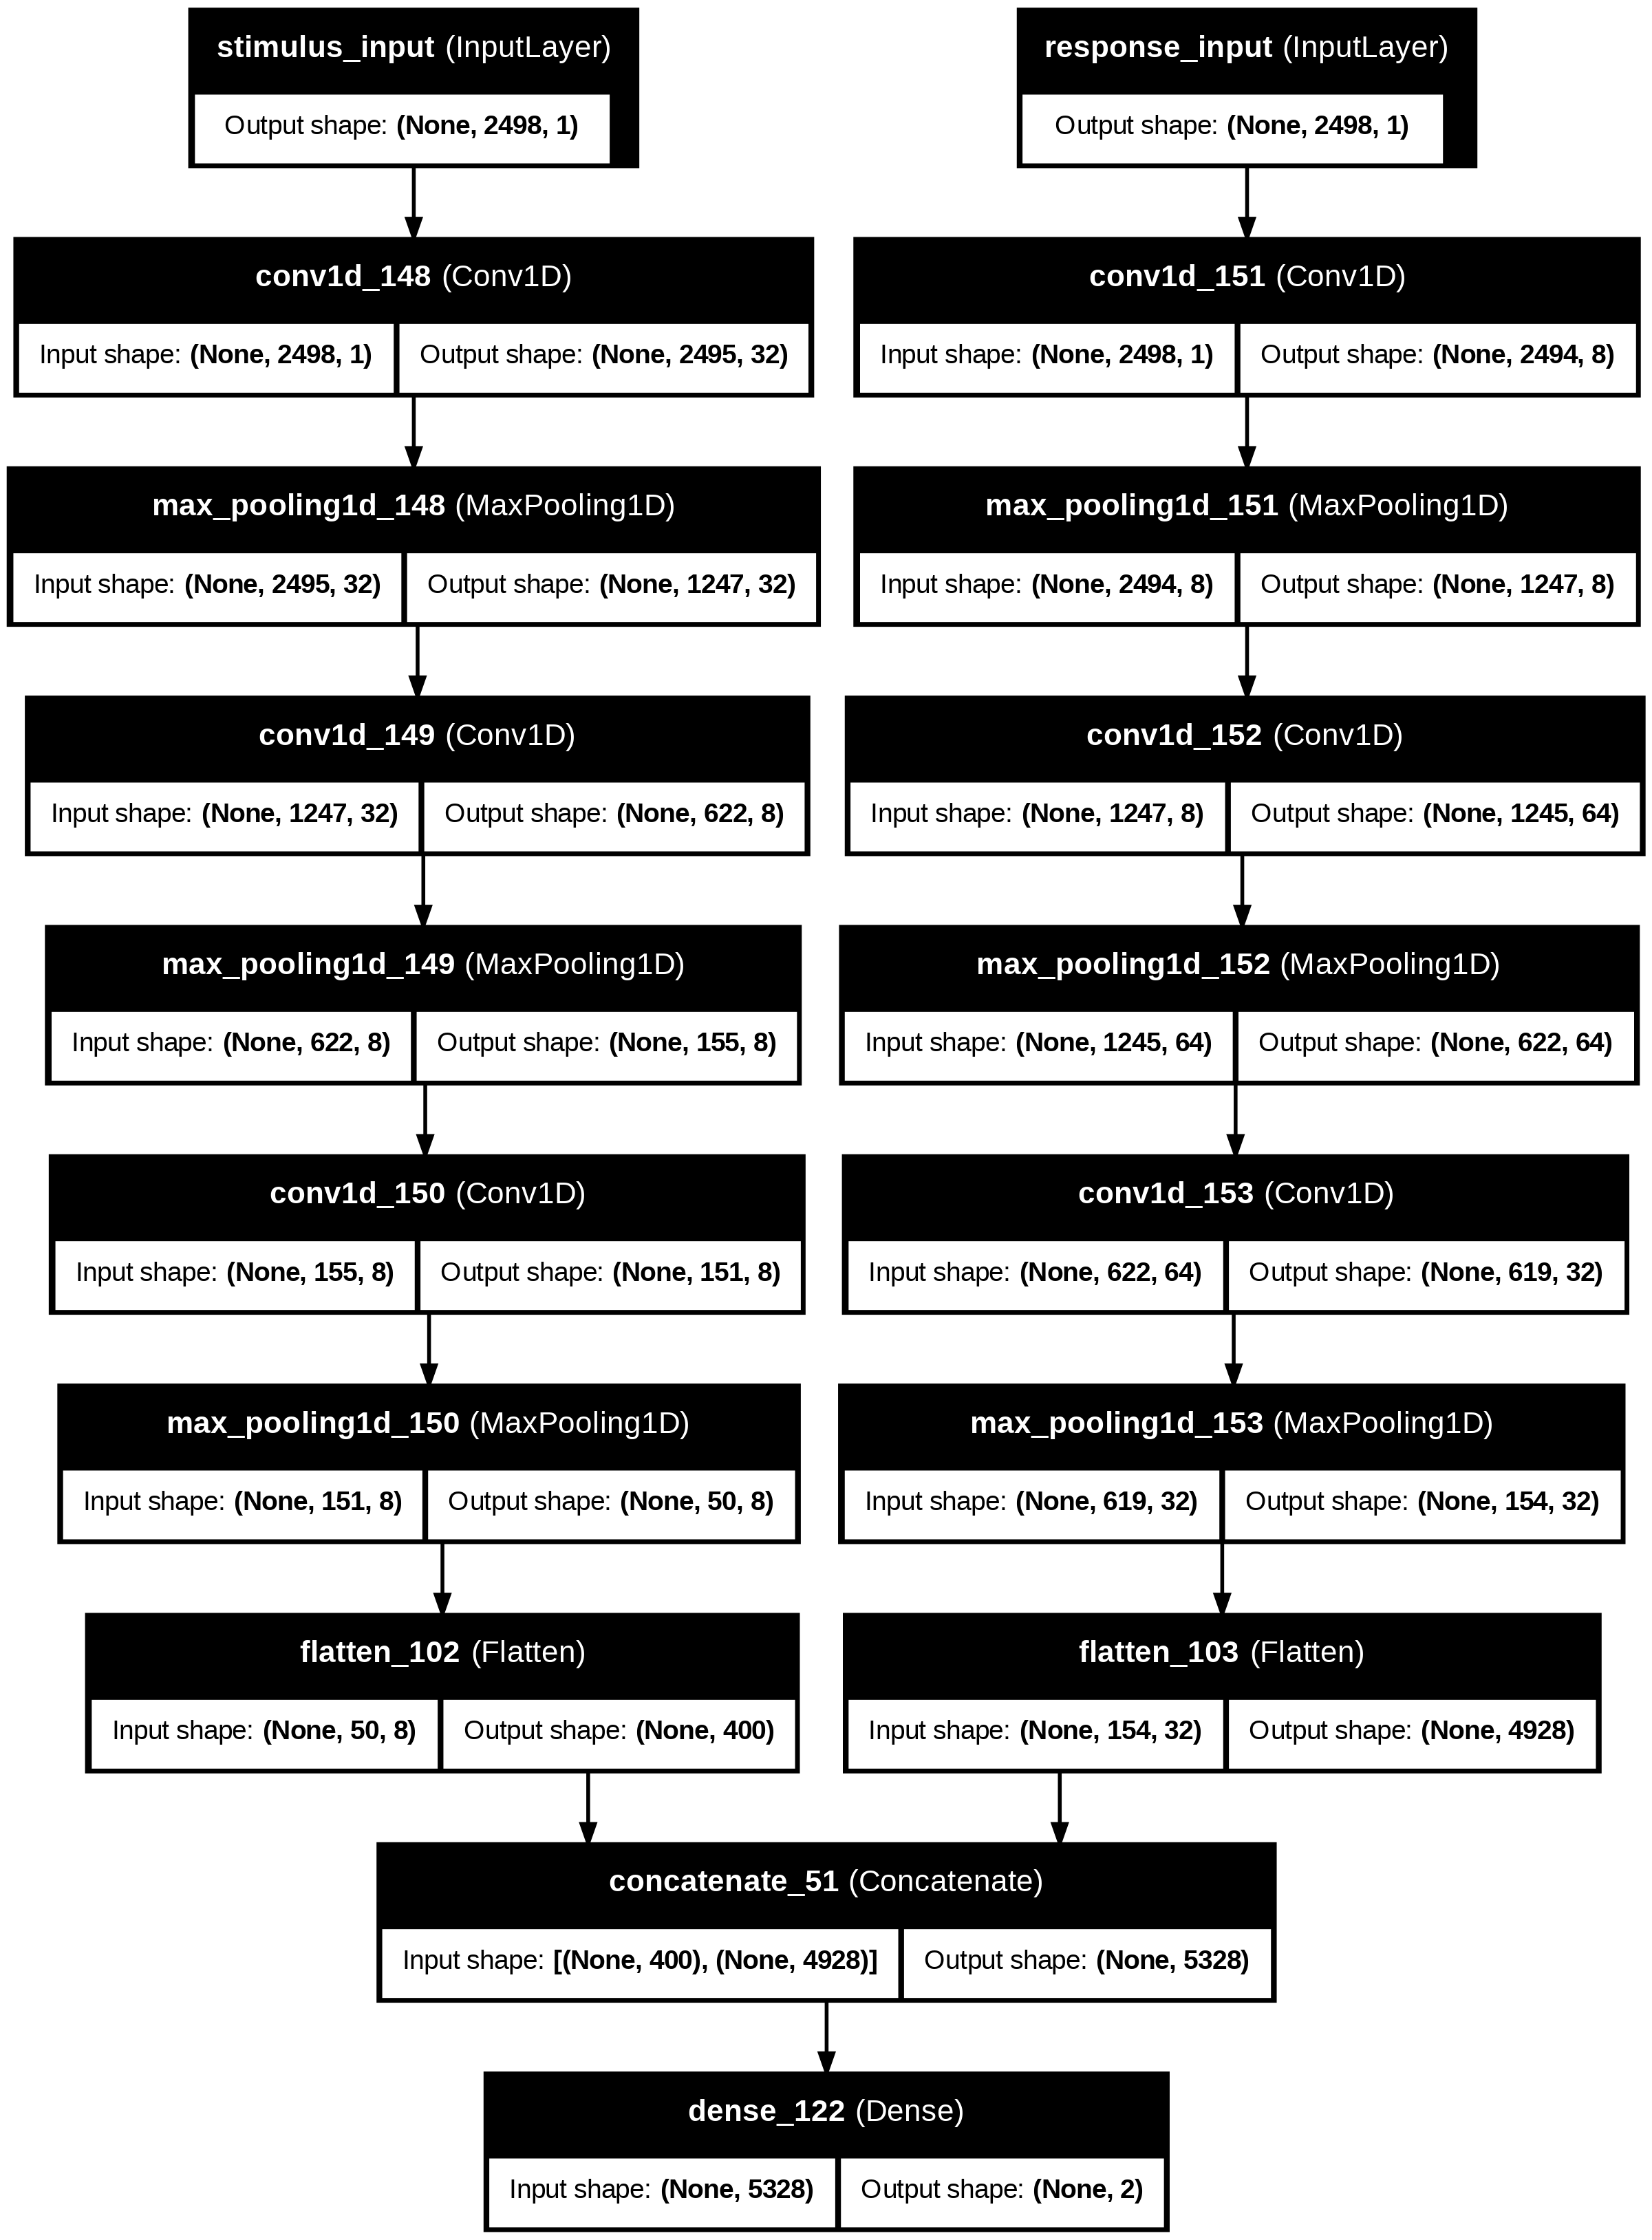

In [ ]:
from keras import utils

utils.plot_model(activation_model, show_shapes=True, show_layer_names=True)